# Exogenous model 


Context: we're trading asset $X$ whose price is driven by an underlying factor $f_t$ acccording to the following relationship:

$$dX_t=\phi(t,f_{0,t})dt+\sigma^XdW_t^X$$


Following the article's approach, we will use the following model:

- $df_t=-\kappa f_t dt+ \sigma^f dW^f_t$
- $Z_t=\int_0^tK(t-s)df_s$
- $dX_t=Z_tdt+\sigma^XdW_t^X$

In the model,

- $f$ is a generic mean-reverting Ornstein-Uhlenbeck process 
- $Z$ is a latent process that contains the information. It is used to recover an exponentially weighted average of previous increments in the signal 
- $X$ behaves like an arithmetic Brownian motion with long term zero drift, but short temporal structure

We opt for an Order 2 Sig Trader approach to better capture the inherent relation between $f$ and $X$. We expect higher functional values (in absolute terms) for the third term of level 1 as well as for some terms in the lower right-hand corner of the level 2 matrix term. Indeed, these terms emphasize the relation between the signal and the underlying asset when trading. 

### 0. Import libraries

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import signatory

sns.set_theme()
reverse = False

### 1. Define some utils 

In [2]:
def K(alpha,t,s): 
    """
    Exponential kernel (decaying function).
    """
    return np.exp(-alpha*(t-s))

def simulate_data(kappa, sigma_f, alpha, sigma_X, T, delta_t, batch_size,X_0):
    """
    Generate synthetic data from the exogenous model.
    """
    #intialisaton
    N=int(T/delta_t)
    f=torch.zeros(batch_size,N+1)
    X=torch.zeros(batch_size,N+1)
    Z=torch.zeros(batch_size,N+1)
    df=torch.zeros(batch_size,N)
    f[:,0]=0
    X[:,0]=X_0
    
    # simulation 
    for i in range(N):
        df_= (- kappa) * f[:, i]*delta_t + sigma_f * torch.randn(batch_size)*np.sqrt(delta_t)
        df[:,i]=df_
        f[:,i+1]=f[:,i]+df_

    for i in range(N):
        Z[:,i]= torch.sum(K(alpha,delta_t*i,delta_t*torch.arange(i))*df[:,:i],dim=1)
        dX = 10 * Z[:,i] * delta_t + sigma_X * torch.randn(batch_size)*np.sqrt(delta_t)
        X[:, i+1] = X[:, i] + dX
    
    return X.unsqueeze(2), f.unsqueeze(2),Z.unsqueeze(2)


def plot_level_2_func(functionals):
    """
    plot the functionals for a level 2 sig model
    """
    print("Level 0")
    print(functionals[0])
    print("")
    print("Level 1")
    print(functionals[1])
    print(functionals[2])
    print(functionals[3])
    print("")
    print("Level 2")
    print(functionals[4:7])
    print(functionals[7:10])
    print(functionals[10:13])

### 2. Generate data

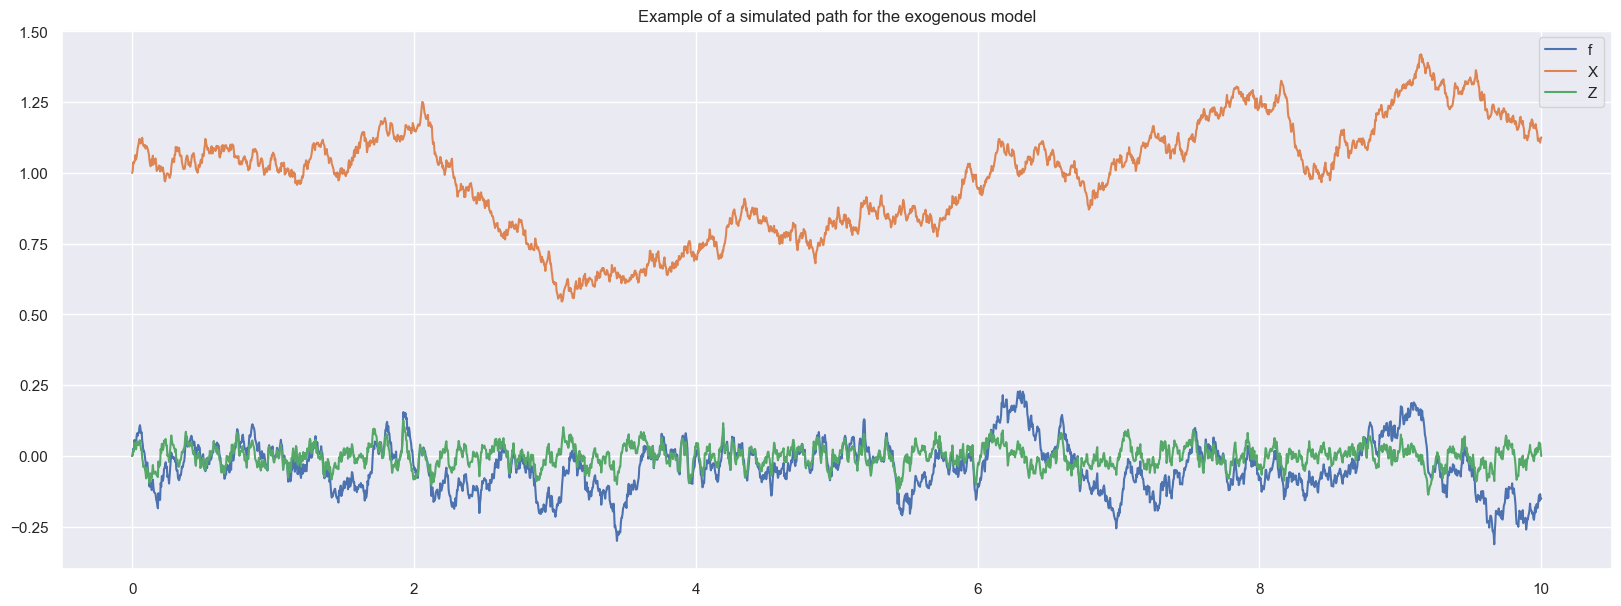

In [3]:
# PARAMETERS OF THE MODEL 

# equation parameters 
kappa=5
sigma_X=0.2
sigma_f=0.3
alpha=25
X_0=1

# time parameters
batch_size=1000
freq=252
delta_t=1/freq
T=10 # we are trading on 10 years !! to see the long term effect of the strategy


X,f,Z=simulate_data(kappa,sigma_f,alpha,sigma_X,T,delta_t,batch_size,X_0)

# print("f_shape",f.shape)
time=torch.linspace(0,T,int(T/delta_t)+1)

plt.figure(figsize=(20,7))
plt.title( "Example of a simulated path for the exogenous model")
plt.plot(time,f[0,:,0].numpy(),label="f")
plt.plot(time,X[0,:,0].numpy(),label="X")
plt.plot(time,Z[0,:,0].numpy(),label="Z")
plt.legend()
plt.show()


### 3. Fit Order 2 Sig Trader

In [4]:
# initialise sig trader 
depth=2
delta=1#variance criterion (only impact: rescale the positions)
ts=trading_strategy.TradingStrategy(depth,delta)

# fit 
ts.fit(X,f)

# plot the functionals
plot_level_2_func(ts.functionals[0])

function compute_signature took 116.95s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

Level 0
tensor(0.7033)

Level 1
tensor(-0.2595)
tensor(4.2032)
tensor(12.7152)

Level 2
tensor([-0.5684,  0.1696, -1.4193])
tensor([-8.3638, -0.7901, -1.5688])
tensor([-28.3629,  -3.7756,   2.9485])


We can notice : 
- The third term of the level 1 signature is bigger than the others
- The term (3,1) of the matrix for level 2 signature is more important than the others

This highlights the importance of explanatory factor in the fitting process 

### 4. Trading with an explanatory factor 

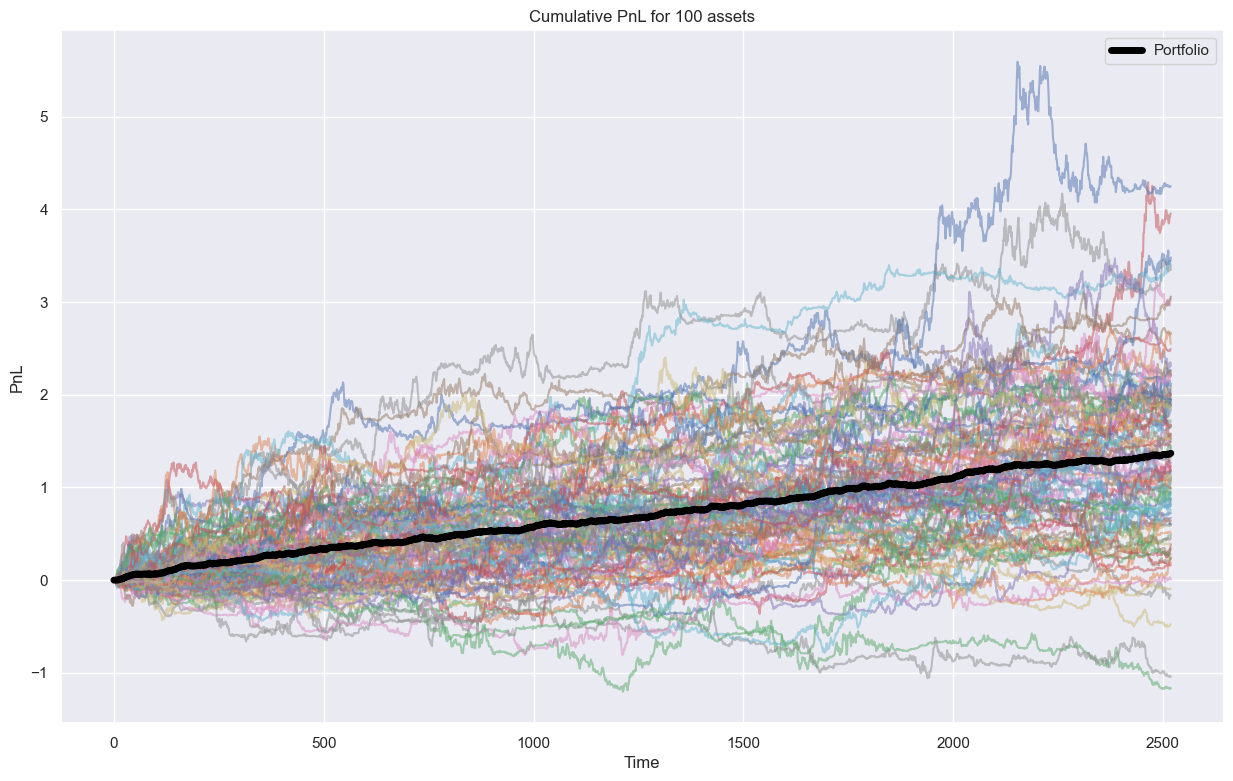

In [5]:
# trade_ samples 
N_samples = 100
T_trade=1
batch_size_trade=1

# for saving purposes 
cum_pnl_samples=[]
cum_pnl_samples_no_info=[]
asset_samples=[]
exogenous_signal_samples=[]

# plot the results
plt.figure(figsize=(15,9))
plt.xlabel("Time")
plt.ylabel("PnL")
plt.title("Cumulative PnL for {} assets".format(N_samples))


for i in range(N_samples):
    X, f,Z = simulate_data(kappa,sigma_f,alpha,sigma_X,T,delta_t,batch_size_trade,X_0)
    X,f=X.squeeze(0),f.squeeze(0)
    asset_samples.append(X ) 
    exogenous_signal_samples.append(f)
    #trade
    
    #with info
    xi=ts.trade(X,f)
    daily_pnl = ts.compute_pnl(X, xi)
    cum_pnl = torch.cumsum(daily_pnl, dim=0).squeeze(1)
    cum_pnl_samples.append(cum_pnl) 

    #no info
    no_info=torch.zeros(f.shape[0],f.shape[1])
    xi_no_info=ts.trade(X,no_info)
    daily_pnl_no_info = ts.compute_pnl(X, xi_no_info)
    cum_pnl_no_info = torch.cumsum(daily_pnl_no_info, dim=0).squeeze(1)
    cum_pnl_samples_no_info.append(cum_pnl_no_info)

    plt.plot(cum_pnl,alpha=0.5)
    

cum_pnl_samples=torch.stack(cum_pnl_samples)
mean_cum_pnl=torch.mean(cum_pnl_samples,dim=0)
cum_pnl_samples_no_info=torch.stack(cum_pnl_samples_no_info)
mean_cum_pnl_no_info=torch.mean(cum_pnl_samples_no_info,dim=0)

plt.plot(mean_cum_pnl,linewidth=5, color="black",label="Portfolio")
plt.legend()

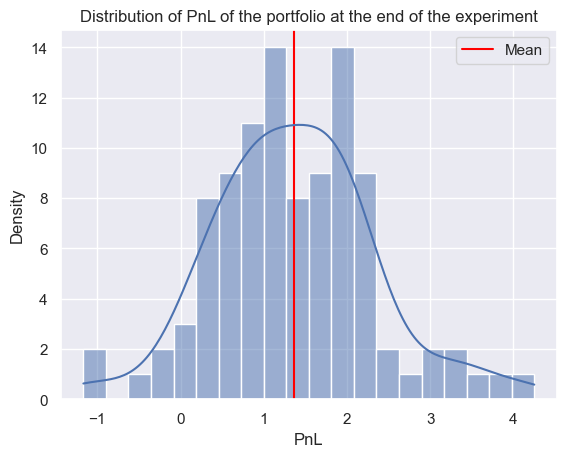

In [8]:
# distribution of PnL of the portfolio
plt.title("Distribution of PnL of the portfolio at the end of the experiment")
plt.xlabel("PnL")
plt.ylabel("Density")
mean_final_pnl=torch.mean(cum_pnl_samples[:,-1])
plt.axvline(mean_final_pnl,color="red",label="Mean")
sns.histplot(np.array(cum_pnl_samples)[:,-1],bins=20,kde=True)
plt.legend()

### 5. Comparing with a raw approach (no additional info)

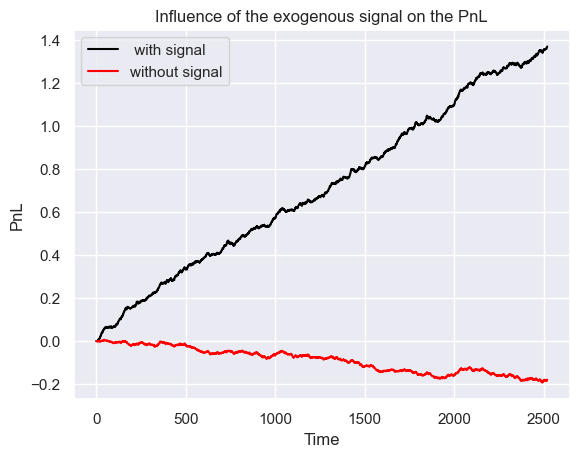

In [9]:
plt.xlabel("Time")
plt.ylabel("PnL")
plt.title("Influence of the exogenous signal on the PnL")
plt.plot(mean_cum_pnl,label=" with signal ",color="black")
plt.plot(mean_cum_pnl_no_info,label="without signal",color="red")
plt.legend()